# Replicating Aaron Brown's value-at-risk methodology described in Wilmott Magazine

Aaron Brown's essay "Forced by the Sternest Circumstances" ([link](https://storage.googleapis.com/wzukusers/user-28782334/documents/595d0085c545cOE8kmtx/Forced%20by%20the%20Sternest%20Circumstances%20200907.pdf), provided on his [website](https://eraider.com/articles)), describes his practical value-at-risk (VaR) approach that hasn't been taught in textbooks.

This notebook is an attempt to replicate two VaR algorithms described therein—the flawed "historical simulation" method and his method, described as a "perfectly simple and obvious way to estimate VaR that works quite well… in one form or another, often deeply disguised, it is at the heart of all successful VaR systems".

**This second method I have failed to fully recreate.** It produces excellent number of breaks but understates the risk, because the average VaR on break days is significantly different than the average overall VaR.

If you want to follow along with this notebook,
- download the daily S&P 500 historic data from Yahoo! Finance ([link](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC)), which gives us data starting from 1928-01-03 (my copy ends on 2020-11-27), and 
- make sure you have installed the following requirements: `pip install pandas scipy` (Scipy is really not necessary, we just use it for the Normal distribution's inverse CDF)

First, let's import some modules, load the raw data into a Pandas dataframe, and compute a daily profit-and-loss (PnL) column.

<AxesSubplot:xlabel='Date'>

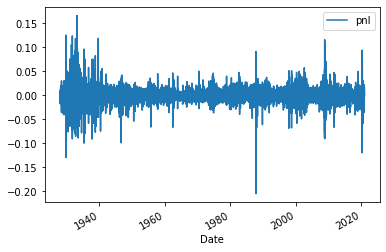

In [1]:
import pandas as pd
from scipy.stats import norm

# https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC daily historical S&P 500 table
df = pd.read_csv('^GSPC.csv', index_col='Date', parse_dates=True)

df['pnl'] = df['Close'].pct_change()
df.pnl.plot(legend=True)

## Historical simulation VaR
The "historical simulation" VaR, assuming a daily 1% VaR, for a given day is computed by finding the 1-percentile PnL over the last few years: Brown uses 3 years, which we convert to days.

In [2]:
p = 0.01 # VaR level
nyears = 3 # years
window = round(5 / 7 * 365.25 * nyears) # points

df['hist_var'] = df['pnl'].rolling(window).quantile(p).shift(1)
# We `shift` by one to put the VaR computed at the *BEGINNING* of a given day at the same row as the *END-OF-DAY* PnL.

Some statistics of the historical simulation VaR:

Number of breaks: 329
Total number of data points: 22554
Average VaR on break: -2.5161%; average overall VaR: -2.8316%


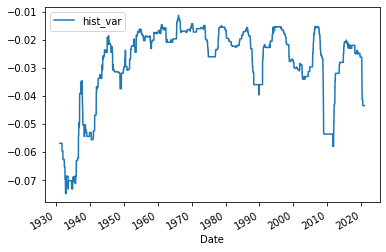

In [3]:
def breaks_levels(breaks: pd.Series, var: pd.Series):
    "Helper function to summarize VaR levels on (and off) VaR breaks"
    return dict(onbreak=var[breaks].mean(),
                notbreak=var[~breaks].mean(),
                all=var.mean())


df['hist_break'] = df.pnl < df.hist_var
levels = breaks_levels(df.hist_break, df.hist_var)

df.hist_var.plot(legend=True)
print(f"Number of breaks: {sum(df.hist_break)}")
print(f"Total number of data points: {len(df.hist_var.dropna())}")
print(f"Average VaR on break: {round(levels['onbreak']*100, 4)}%; average overall VaR: {round(levels['all']*100, 4)}%")

At the time his piece was published, Brown's dataset allowed for 19922 predictions and of those, 314 were breaks—far too many.

We have more data than that: our total dataset is, as printed above, 22554 long. However, 1% of that is only 233, and we found 329 breaks, in line with his findings.

Brown reports that his average historical simulation VaR was -0.026500% while the average VaR *on breaks* was -2.4100% (actually he cites these as losses per million dollars in the S&P 500, so the numbers he provides are \\$26,500 and \\$24,100, respectively).

As printed above, we find an average overall VaR of -2.8316% and average *on breaks* was -2.5161% (converting to loss per million dollars, \\$28,316 and \\$25,161, respectively).

The average VaRs we find are lower (more loss) than Brown found, though recall that he had less data since his article was published some years ago (I can't tell exactly when, though his hint that he had 19922 days could help). Curiously, however, our historical simulation VaR never gets as high as -2.6%, as we see below: maybe his data started a bit before our data?

Maximum average historical simulation VaR: -2.7392%


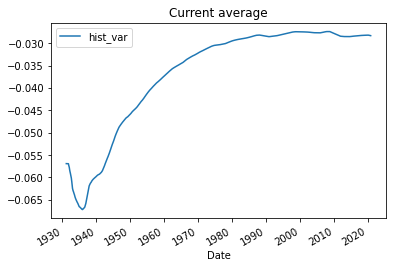

In [4]:
v = df.hist_var.expanding().mean()
v.plot(title='Current average', legend=True)
print(f"Maximum average historical simulation VaR: {round(v.max()*100, 4)}%")

This small worries aside, I believe we've correctly implemented the historical simulation VaR and noted its drawbacks: too many breaks and significantly different VaRs on breaks than in general.

We don't even consider the third requirement for VaR, ensuring that breaks are randomly distributed through time, because my implementation of Brown's favored VaR technique, while producing a much better number of breaks, also produced different VaRs on breaks than in general.

## Brown's Bayesian VaR
This algorithm considers the trailing 3-year standard deviation of PnL, scaled by 2.33 (the inverse CDF (cumulative distribution function) of the Normal distribution at 1-percentile). Then:
- if yesterday was a break, today's VaR is twice yesterday's VaR.
- Otherwise, today's VaR is 0.94 times yesterday's VaR plus 0.06 times the scaled trailing standard deviation.

The following implements this. It's a bit slow (taking ~20 seconds on my Intel CPU).

In [5]:
std_scalar = abs(norm.ppf(p)) # approximately 2.33 for p=0.01
df['scaled_std'] = df.pnl.rolling(window).std().shift(1) * std_scalar
# We `shift` by 1, as above, so that the `scaled_std` of a given row
# corresponds to the value as of that morning before trading began

def add_b_var(df):
    "Add Brown Bayesian VaR column to dataframe"
    # Init b-var as the NEGATIVE scaled standard deviations.
    # This only matters for the first day, but in general we want 
    # to use the negative std because we care about the left side
    # of the distribution: the *loss*
    df['b_var'] = df.scaled_std.copy() * -1

    # find the numeric index of b_var so we can overwrite it
    b_var_idx = list(df.columns).index('b_var')

    # loop over each adjacent pair of rows, except the very last row
    for i in range(len(df) - 1):
        yesterday = df.iloc[i]

        # skip the first several rows we used for "training" (we could use df.dropna too)
        if yesterday.isnull().any():
            continue

        today = df.iloc[i + 1]
        b_break = yesterday.pnl < yesterday.b_var
        if b_break:
            df.iloc[i + 1, b_var_idx] = 2 * yesterday.b_var
        else:
            df.iloc[i + 1, b_var_idx] = 0.94 * yesterday.b_var + 0.06 * -today.scaled_std
            # Recall that `today.scaled_std` is the trailing scaled std as of this morning
            # We're not cheating by using that here: it includes only yesterday's close
    return df


df = add_b_var(df)

Number of breaks: 207
Total number of data points: 22554
Average VaR on break: -2.6993%; average overall VaR: -2.8966%


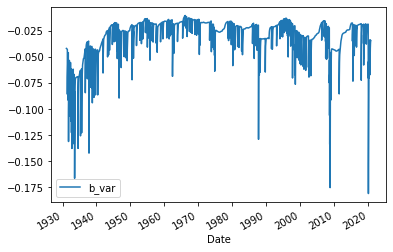

In [6]:
df['b_break'] = df.pnl < df.b_var
b_levels = breaks_levels(df.b_break, df.b_var)

df.b_var.plot(legend=True)
print(f"Number of breaks: {sum(df.b_break)}")
print(f"Total number of data points: {len(df.b_var.dropna())}")
print(f"Average VaR on break: {round(b_levels['onbreak']*100, 4)}%; average overall VaR: {round(b_levels['all']*100, 4)}%")

For Brown, this VaR broke 188 times, with an expected 199 breaks. We likewise do well, with 207 breaks out of an expected 226 (22,554 days times 1%).

**However.** Our average VaR is -2.8966% whereas our average VaR *on breaks* is -2.6993% (or, in loss per million, \\$28,966 versus \\$26,993 respectively). These two averages are still *significantly different*.

In contrast, Brown found that the two averages, all VaR and VaR on breaks, to be much closer: -2.51% and -2.57% respectively (or, in loss per million, which is what he gives in the article, \\$25,100 and \\$25,700 respectively). He applauded how close these two were, and also that the VaR on breaks was a bit lower (more loss) than usual: you want to overestimate risk before a big loss than underestaimate it.

Brown also asserts that this technique, which he simply calls Bayesian VaR, yields good performance for a range of reasonable numbers (0.94 decay factor and 3 years window). I tweaked the algorithm in any number of ways but couldn't narrow the gap between the average VaR and average VaR on breaks.

> The only exception was found via a bug. If instead of a loss-VaR we flip the sign of the PnL to get a VaR such that 1% of the time our **profit** will be greater than the VaR, then we find the average profit-VaR to be close to the average profit-VaR on "breaks":

In [7]:
profit_df = df.copy()
profit_df.pnl *= -1 # flip profit and loss
profit_df = add_b_var(profit_df)

Number of breaks: 205
Average VaR on break: -2.8688%; average overall VaR: -2.9183%
Maximum average profit-VaR: -2.8301%


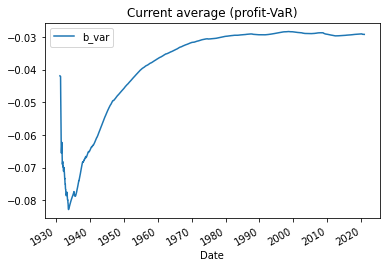

In [8]:
profit_df['b_break'] = profit_df.pnl < profit_df.b_var
b_levels2 = breaks_levels(profit_df.b_break, profit_df.b_var)
print(f"Number of breaks: {sum(profit_df.b_break)}")
print(f"Average VaR on break: {round(b_levels2['onbreak']*100, 4)}%; average overall VaR: {round(b_levels2['all']*100, 4)}%")

v = profit_df.b_var.expanding().mean()
v.plot(title='Current average (profit-VaR)', legend=True)
print(f"Maximum average profit-VaR: {round(v.max()*100, 4)}%")

This profit-VaR isn't very useful as a risk measure, but it does have a close-to-expected number of breaks and strikingly, its average profit-VaR and average profit-VaR on breaks are very close.

## Conclusion
Without knowing more precisely what dates Brown's analysis covered, it's hard to know why my implementation of his Bayesian VaR fails to meet the requirement that VaR breaks be independent of the level of the VaR. I could have a bug, and I hope to invite eyeballs to critique my implementation above. I also have gently tried tweaking the algorithm a bit (tweaking the 0.94 parameter, using partial data at the beginning to compute rolling standard deviations, etc.) but have been unable to fix this issue.

(In the third requirement for a VaR, that the timing of breaks is independent, my implementation of Brown's Bayesian VaR does quite well, matching Brown's findings in his article, but I haven't shown that above to keep the code focused on the one problem I do have.)

Please feel free to [get in touch](https://fasiha.github.io/#contact).

—Ahmed Fasih